# Term Deposit Marketing
### Noah Cox

 *Import Packages*

In [23]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
import scipy.stats as stats
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from imblearn.over_sampling import SMOTE

*sanity-check path*

In [24]:
sys.path

['O:\\Term_Repo\\notebooks',
 'C:\\Users\\noahc\\anaconda3\\python38.zip',
 'C:\\Users\\noahc\\anaconda3\\DLLs',
 'C:\\Users\\noahc\\anaconda3\\lib',
 'C:\\Users\\noahc\\anaconda3',
 '',
 'C:\\Users\\noahc\\AppData\\Roaming\\Python\\Python38\\site-packages',
 'C:\\Users\\noahc\\anaconda3\\lib\\site-packages',
 'C:\\Users\\noahc\\anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\noahc\\anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\noahc\\anaconda3\\lib\\site-packages\\Pythonwin']

*import data*

In [25]:
%cd O:\Term_Repo\data\raw
df = pd.read_csv("term-deposit-marketing-2020.csv")

%cd O:\Term_Repo\notebooks

O:\Term_Repo\data\raw
O:\Term_Repo\notebooks


## *Data Visualization*

In [26]:
df.head(6)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,no


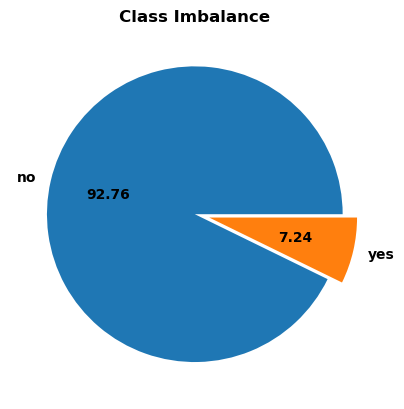

In [27]:
plt.pie(df['y'].value_counts(),labels=df['y'].value_counts().index,autopct='%.2f',explode=[0,0.1])
plt.title("Class Imbalance")
plt.show()

Text(0.5, 0.98, 'Visualizing Continuous Columns')

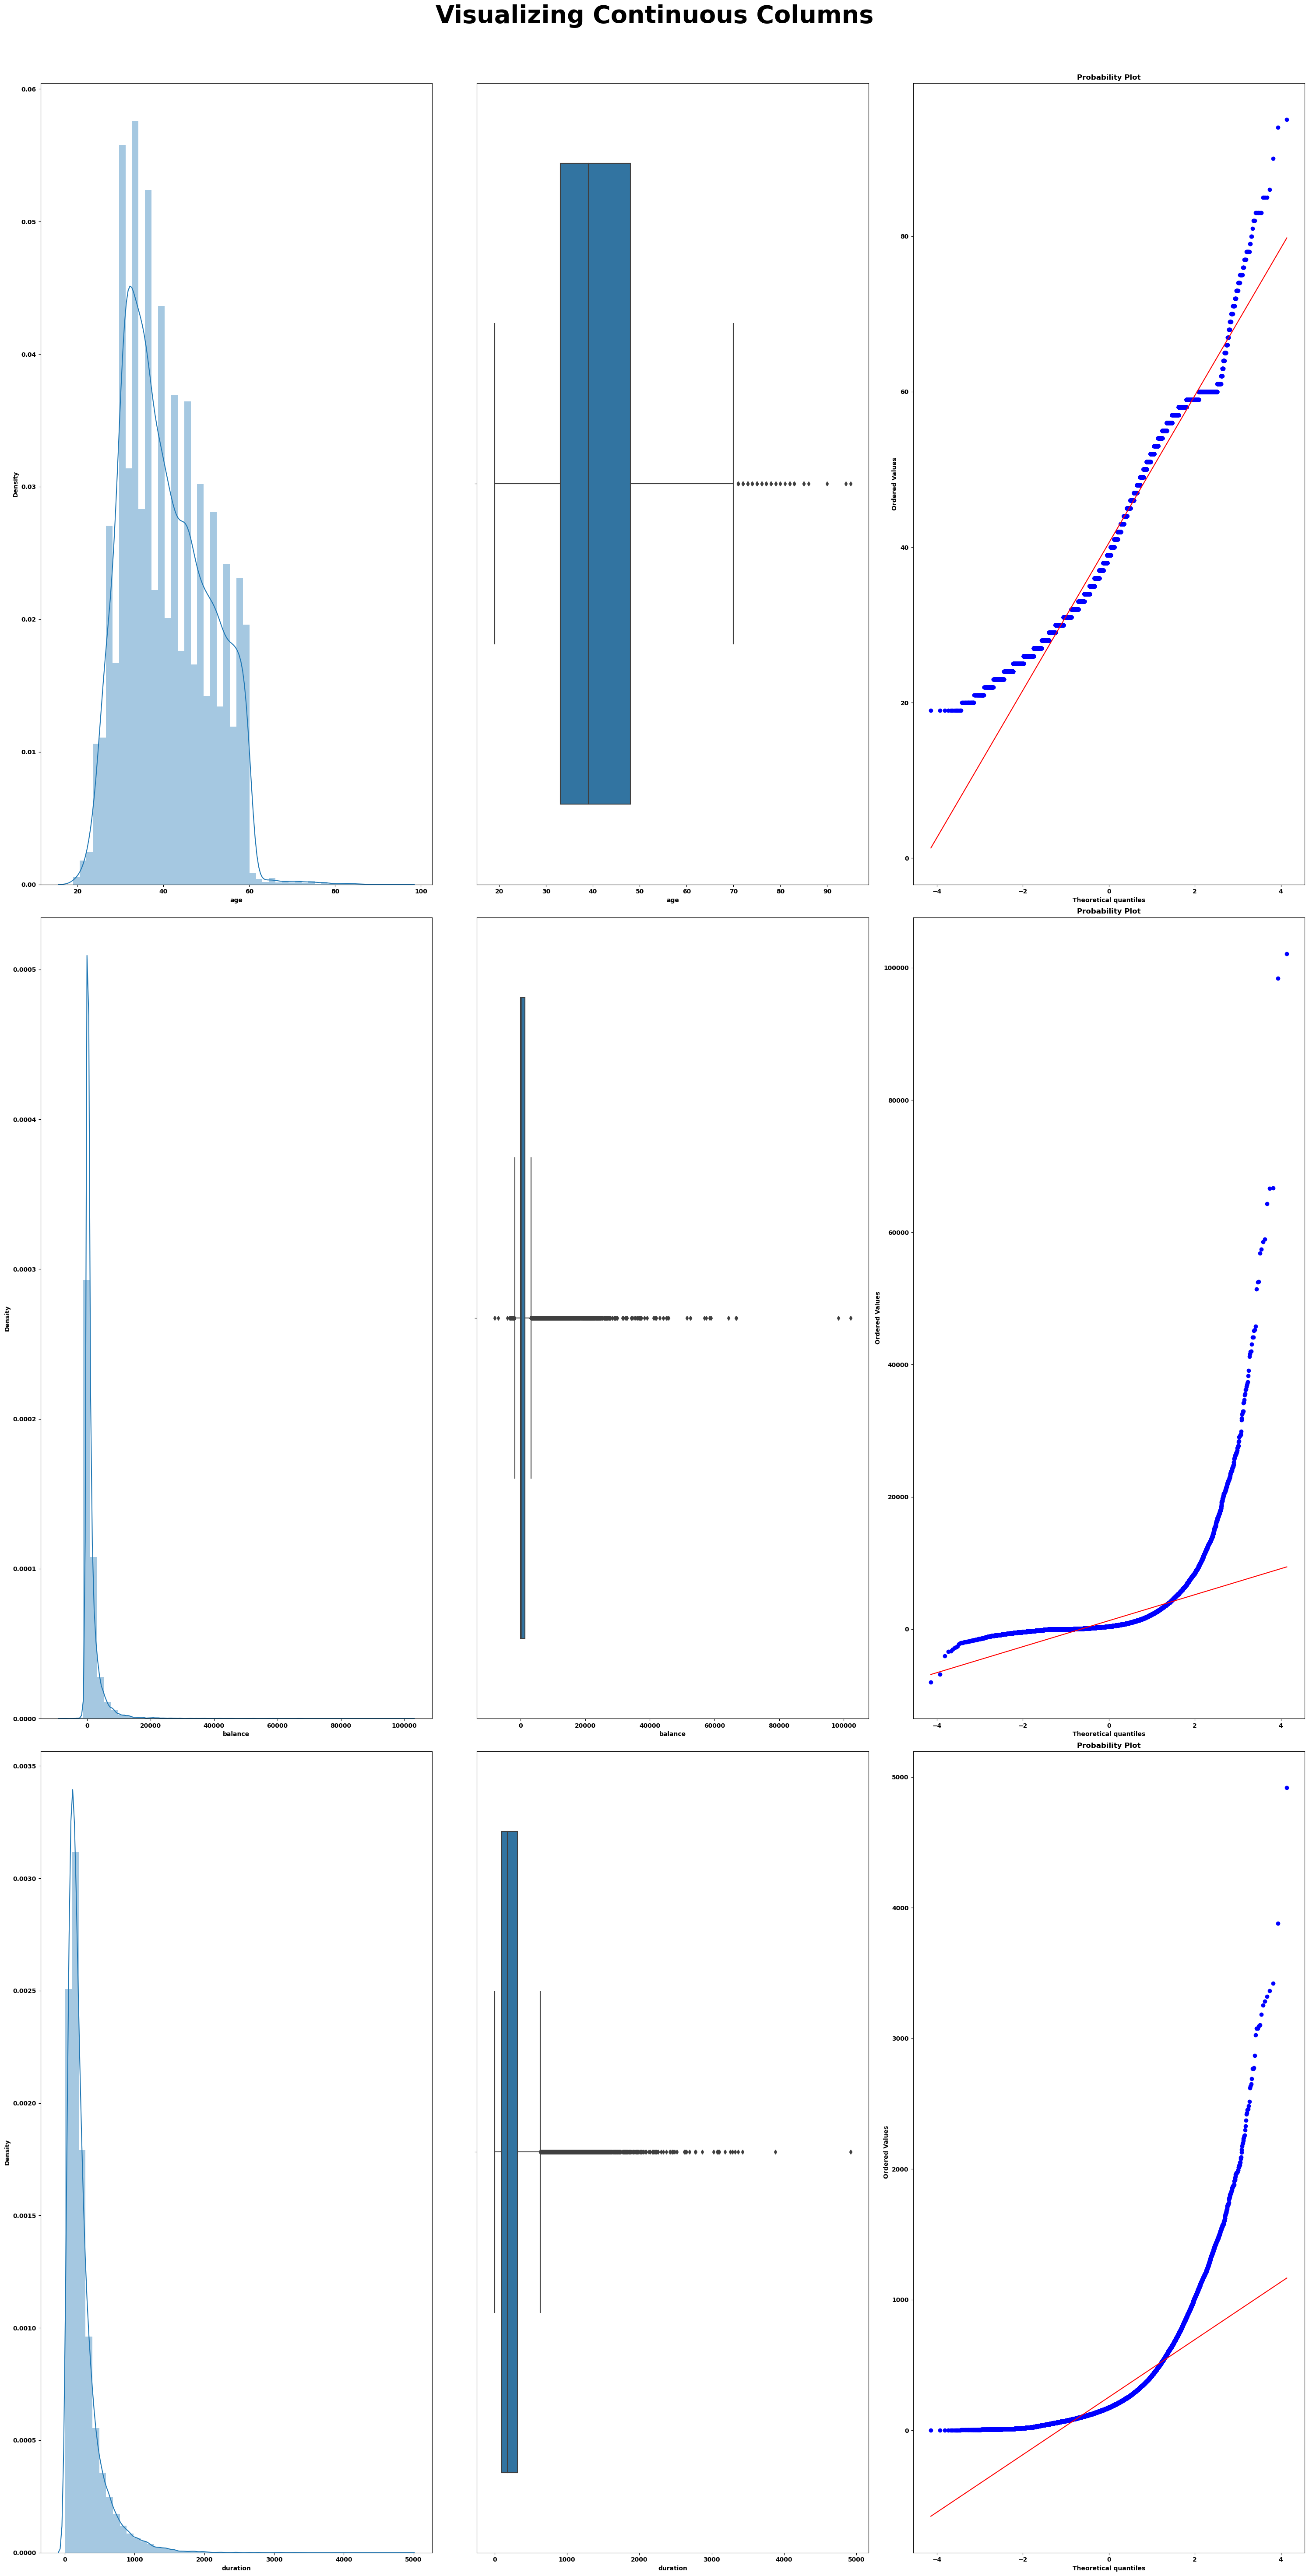

In [28]:
warnings.filterwarnings('ignore')

fig,ax = plt.subplots(3,3,figsize=(30,60))
for index,i in enumerate(df.iloc[:,[0,5,11]]):
    sns.distplot(df[i],ax=ax[index,0])
    sns.boxplot(df[i],ax=ax[index,1])
    stats.probplot(df[i],plot=ax[index,2])
    
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.suptitle("Visualizing Continuous Columns",fontsize=40)

# Data Preprocessing

### replace binary categorical features

In [29]:
df['default'].replace(['no', 'yes'],
                        [0, 1], inplace=True)
df['housing'].replace(['no', 'yes'],
                        [0, 1], inplace=True)
df['loan'].replace(['no', 'yes'],
                        [0, 1], inplace=True)
df['y'].replace(['no', 'yes'],
                        [0, 1], inplace=True)
df['month'].replace(['jan', 'feb', 'mar', 'apr', 'may', 'jun','jul','aug', 'sep','oct', 'nov', 'dec'],
                        [1,2,3,4,5,6,7,8,9,10,11,12], inplace=True)

In [30]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,5,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,5,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,5,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,5,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,5,198,1,0


### encode multi label categories with dummy variables

In [31]:
job = df.job
jobencode = pd.get_dummies(job)

In [32]:
marital = df.marital
maritalencode = pd.get_dummies(marital)

In [33]:
education = df.education
educationencode = pd.get_dummies(education)

In [34]:
contact = df.contact
contactencode = pd.get_dummies(contact)

### append new encoded columns and drop old categorical columns

In [35]:
dft = pd.concat([df,maritalencode],
                axis = 1)

In [36]:
dft = pd.concat([dft,educationencode],
                axis=1)

In [37]:
dft = pd.concat([dft,contactencode],
                axis=1)

In [38]:
dft = pd.concat([dft,jobencode],
                 axis=1)

In [39]:
dft = dft.drop(['job','marital','education','contact'], axis = 1)

### pop y to first column

In [40]:
column_to_move = dft.pop("y")

# insert column with insert(location, column_name, column_value)

dft.insert(0, "y", column_to_move)

### visualizing column correlation

<AxesSubplot:>

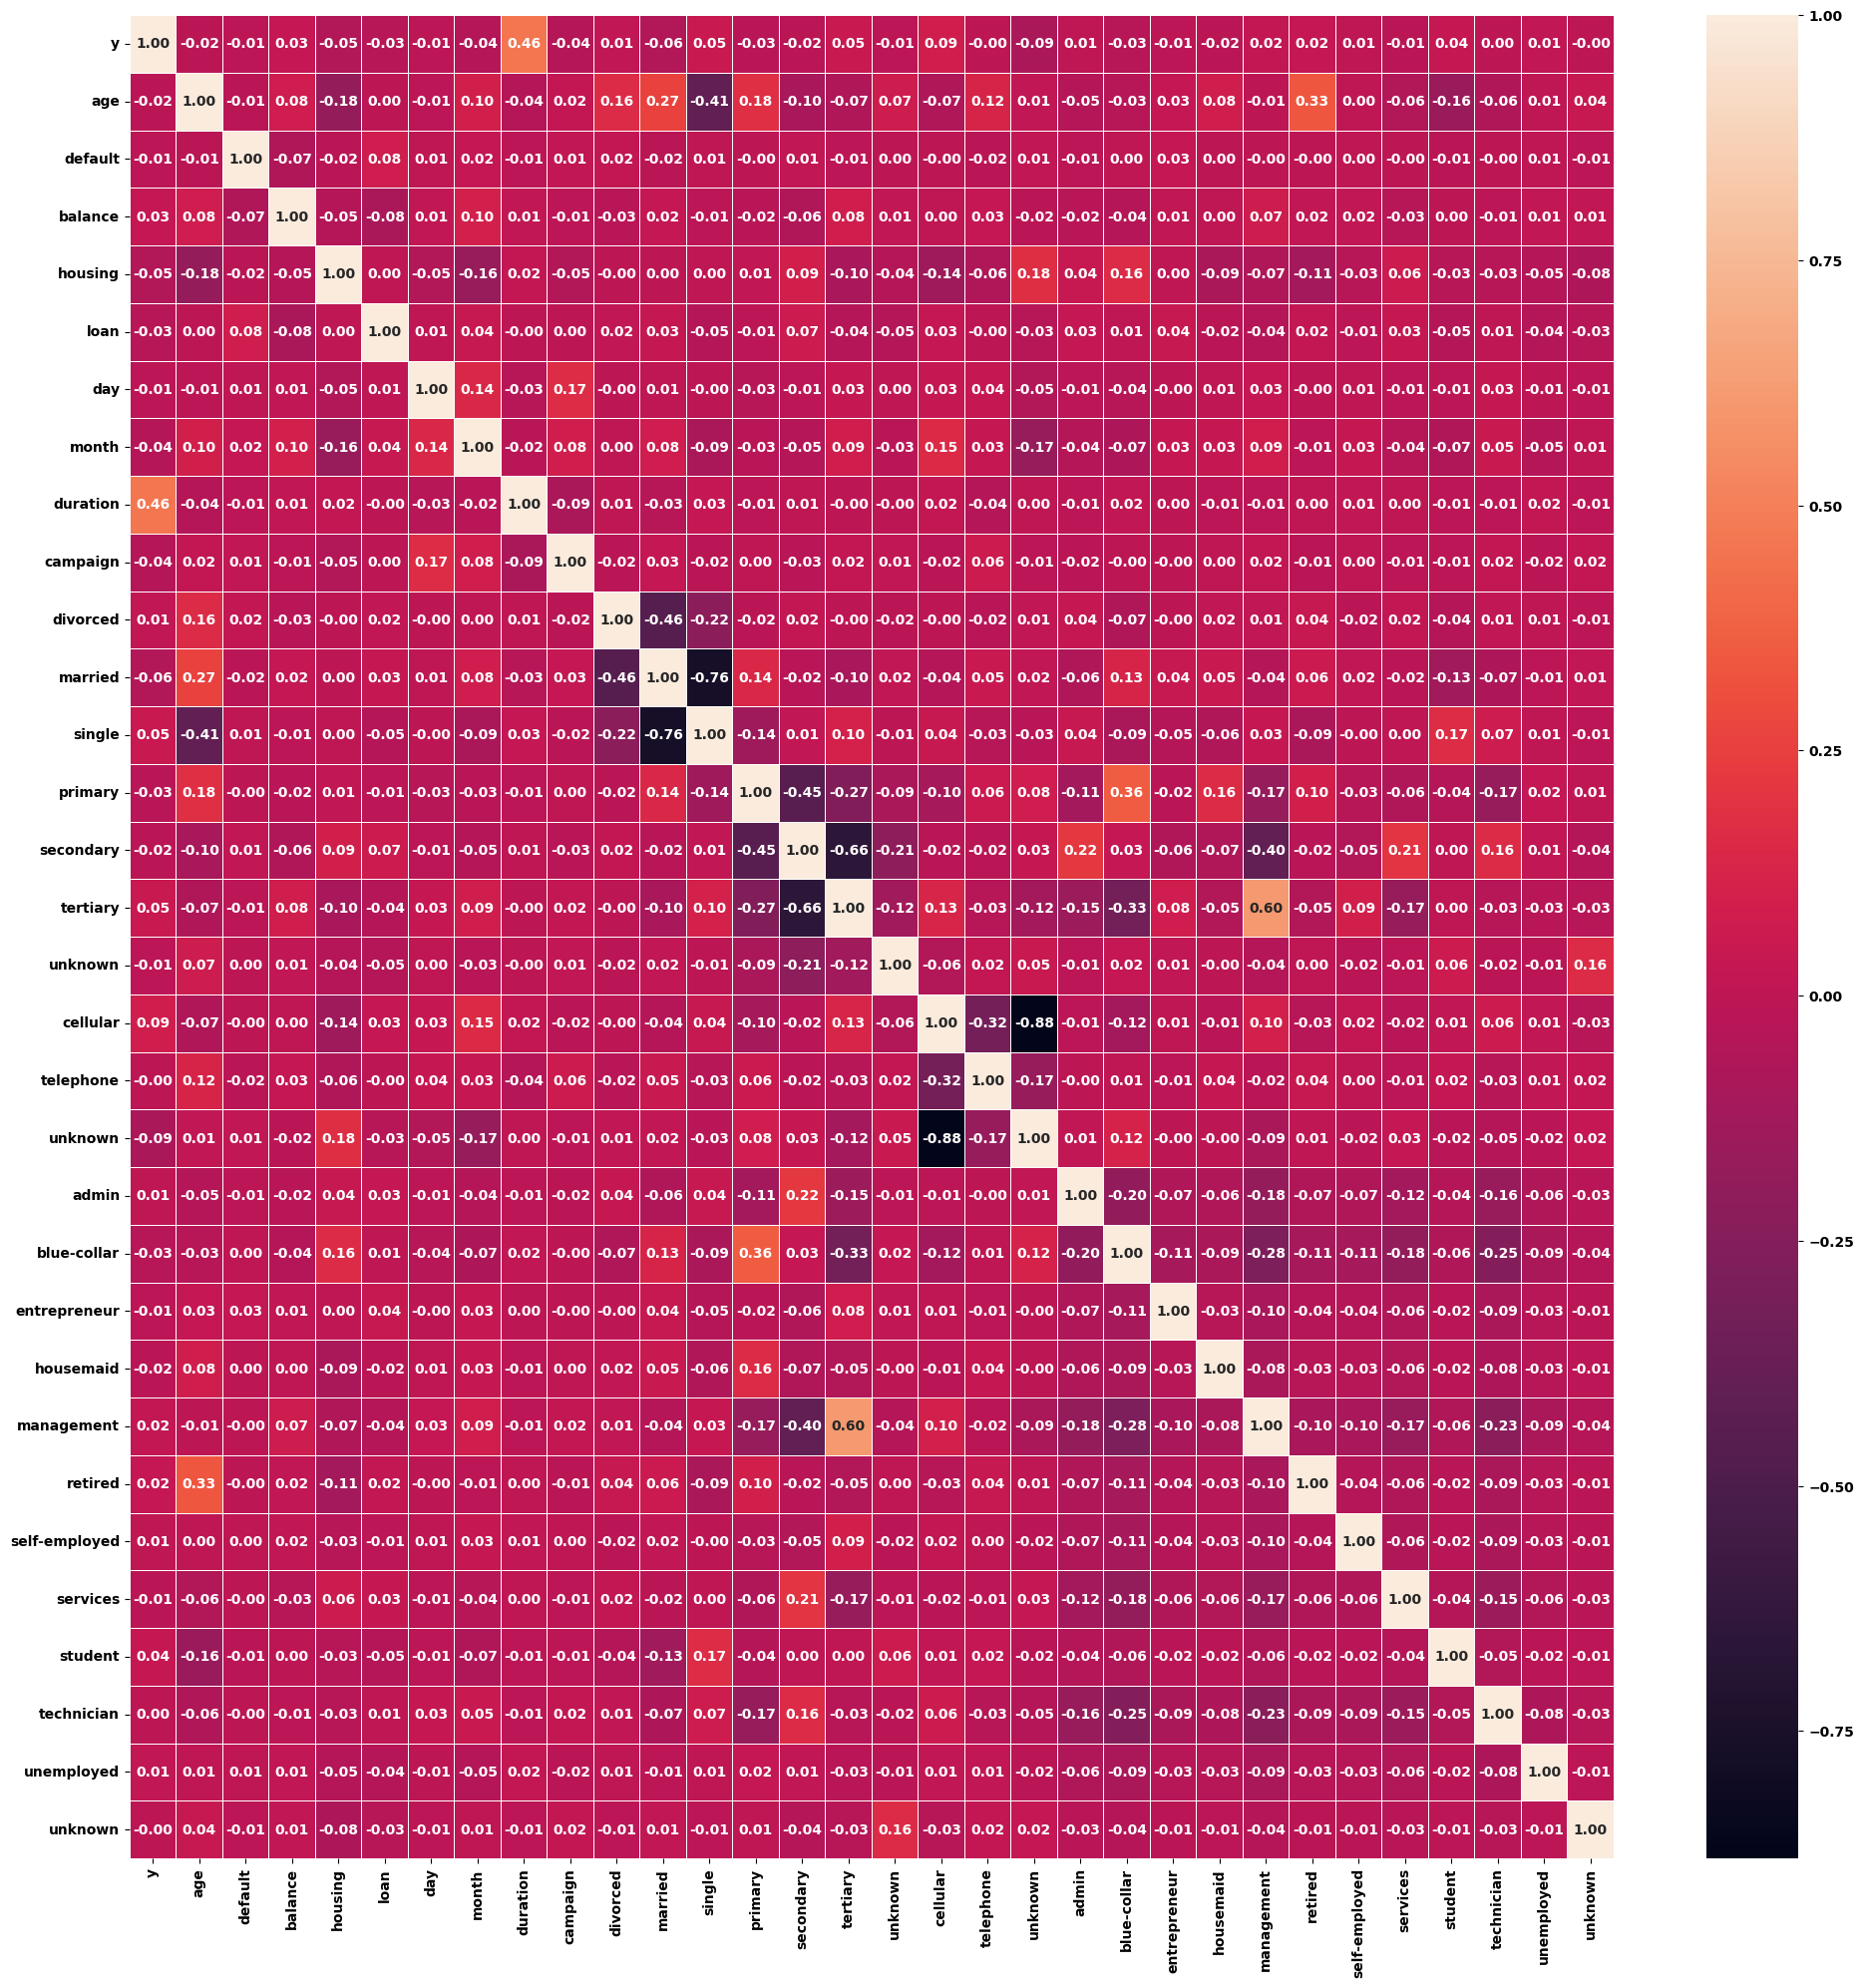

In [41]:
plt.figure(figsize=(24,24))
sns.heatmap(dft.corr(),annot=True,linewidth=0.5,fmt="0.2f")

In [42]:
dft.head()

,y,age,default,balance,housing,loan,day,month,duration,campaign,...,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
0,0,58,0,2143,1,0,5,5,261,1,...,0,0,1,0,0,0,0,0,0,0
1,0,44,0,29,1,0,5,5,151,1,...,0,0,0,0,0,0,0,1,0,0
2,0,33,0,2,1,1,5,5,76,1,...,1,0,0,0,0,0,0,0,0,0
3,0,47,0,1506,1,0,5,5,92,1,...,0,0,0,0,0,0,0,0,0,0
4,0,33,0,1,0,0,5,5,198,1,...,0,0,0,0,0,0,0,0,0,1


# Feature Selection

### Slicing features

In [43]:
sliced_features = dft.iloc[:,1:]
sliced_labels = dft['y']
sliced_features.head()


,age,default,balance,housing,loan,day,month,duration,campaign,divorced,...,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
0,58,0,2143,1,0,5,5,261,1,0,...,0,0,1,0,0,0,0,0,0,0
1,44,0,29,1,0,5,5,151,1,0,...,0,0,0,0,0,0,0,1,0,0
2,33,0,2,1,1,5,5,76,1,0,...,1,0,0,0,0,0,0,0,0,0
3,47,0,1506,1,0,5,5,92,1,0,...,0,0,0,0,0,0,0,0,0,0
4,33,0,1,0,0,5,5,198,1,0,...,0,0,0,0,0,0,0,0,0,1


### correlation based feature selection and z-score outlier removal

In [44]:

#feature selection
#fs = SelectKBest(score_func=f_classif, k=25)
#X_selected = fs.fit_transform(sliced_features, sliced_labels)

#Checking which features where selected
#filter = fs.get_support()
#feat = np.array(sliced_features.columns)
#print('Total Features ', feat)
#print('Selected Features for training ',feat[filter])

#remove outliers
#z = np.abs(stats.zscore(X_selected))
#inputs = X_selected[(z<3).all(axis=1)]
#target = sliced_labels[(z<3).all(axis=1)]

### scale-split-balance

In [45]:
sc = StandardScaler()
inputs = sc.fit_transform(sliced_features)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(inputs, sliced_labels, random_state=1234)

In [47]:
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)
#X_test, y_test = sm.fit_resample(X_test, y_test)
print(X_train.shape)
print(X_test.shape)


(55642, 31)
(10000, 31)


# Gradient Boosting Model

In [ ]:
param_grid = {
    'learning_rate' : [.475],
    'n_estimators': [300],
}

gbc=GridSearchCV(GradientBoostingClassifier(),param_grid,cv=15, verbose = 1000)
gbc.fit(X_train,y_train)


Fitting 15 folds for each of 1 candidates, totalling 15 fits
[CV 1/15; 1/1] START learning_rate=0.475, n_estimators=300......................
[CV 1/15; 1/1] END learning_rate=0.475, n_estimators=300;, score=0.564 total time=  36.5s
[CV 2/15; 1/1] START learning_rate=0.475, n_estimators=300......................
[CV 2/15; 1/1] END learning_rate=0.475, n_estimators=300;, score=0.942 total time=  35.2s
[CV 3/15; 1/1] START learning_rate=0.475, n_estimators=300......................
[CV 3/15; 1/1] END learning_rate=0.475, n_estimators=300;, score=0.984 total time=  36.7s
[CV 4/15; 1/1] START learning_rate=0.475, n_estimators=300......................
[CV 4/15; 1/1] END learning_rate=0.475, n_estimators=300;, score=0.983 total time=  35.5s
[CV 5/15; 1/1] START learning_rate=0.475, n_estimators=300......................
[CV 5/15; 1/1] END learning_rate=0.475, n_estimators=300;, score=0.985 total time=  35.1s
[CV 6/15; 1/1] START learning_rate=0.475, n_estimators=300......................
[CV

In [ ]:
y_pred_gbc=gbc.predict(X_test)
confusion_gbc=confusion_matrix(y_test,y_pred_gbc)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_gbc,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
print(classification_report(y_test,y_pred_gbc))
print(f'\nBest Parameter: {gbc.best_params_}\n')

# BANG

In [ ]:
'''
estimator = []
estimator.append(('RFC', 
                   RandomForestClassifier(n_estimators= 300, max_features= 'log2', max_depth= 8)))
estimator.append(('SVC', SVC(kernel='rbf', gamma= 1, C=100)))
estimator.append(('GBC', GradientBoostingClassifier(n_estimators = 50, learning_rate =0.05)))
            
vot_hard = VotingClassifier(estimators = estimator, voting ='hard', verbose = 1000)
vot_hard.fit(X_train,y_train)
'''

In [ ]:
'''
y_pred= vot_hard.predict(X_test)
confusion=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(confusion,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
print(classification_report(y_test,y_pred))
'''